In [9]:
import pandas as pd

import sklearn
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm

import matplotlib.pyplot as plt

from main import find_index, carry_out_recursive_feature_elimination

In [10]:
df = pd.read_csv(                                                                                                                       
    "../../../data/processed/full/std/per_opponent/main.csv"                                                                            
)                                                                                                                                       
                                                                                                                                        
moran_df = pd.read_csv("../../img/compare-fixation-to-sserror/data/main.csv")                                                                                                 
moran_df["Player index"] = moran_df["player"].map(find_index)                                                                           
moran_df["Opponent index"] = moran_df["opponent"].map(find_index)                                                                       
moran_df["Normalised fixation"] = moran_df["$p_1$"] * moran_df["N"]                                                                     
df = moran_df.merge(                                                                                                                    
    df, on=("Player index", "Opponent index"), how="right"                                                                              
)                                                                                                      

In [11]:
aggregate_df = df.groupby("Player index").agg(["mean", "median", "std", "max", "min", "var"]).dropna()
Y = aggregate_df["Normalised fixation"]["mean"]
X = aggregate_df[["residual", "chi"]]

In [12]:
Y.head()

Player index
0    1.806446
1    1.420587
2    1.274116
4    1.045840
5    1.105582
Name: mean, dtype: float64

In [13]:
X.head()

residual                                                        \
                  mean    median       std       max           min       var   
Player index                                                                   
0             0.085234  0.062500  0.098870  0.529421  4.962440e-07  0.009775   
1             0.735523  1.235294  0.557780  1.235294  0.000000e+00  0.311119   
2             0.146359  0.058824  0.227649  1.100579  2.765522e-04  0.051824   
4             0.058353  0.034575  0.103270  0.490000  0.000000e+00  0.010665   
5             1.318780  1.529412  0.357273  1.941176  3.823529e-01  0.127644   

                    chi                                              \
                   mean     median        std        max        min   
Player index                                                          
0             -2.589143  -1.000000  11.774558  20.219352 -26.309607   
1              0.794683   0.062500   1.891261  15.749016  -2.892567   
2              0.534406  -2.888889   6.730720  15.982968  -7.190259   
4             13.046538  16.000000   6.253074  16.000000  -1.000000   
5              2.616834   3.857143   5.372014   5.375000 -26.500000   

                          
                     var  
Player index              
0             138.640215  
1               3.576868  
2              45.302588  
4              39.100936  
5              28.858535

Confirm the model currently in the manuscript:

In [14]:
model = sm.OLS(Y, sm.add_constant(X["residual"]["var"])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     24.94
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           1.56e-06
Time:                        16:31:31   Log-Likelihood:                -61.088
No. Observations:                 159   AIC:                             126.2
Df Residuals:                     157   BIC:                             132.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1102      0.057     19.463      0.000       0.998       1.223
var            1.2728      0.255      4.994      0.000       0.769       1.776
==============================================================================
Omnibus:                        4.032   Durbin-Watson:                   1.547
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                3.575
Skew:                          -0.348   Prob(JB):                        0.167
Kurtosis:                       3.237   Cond. No.                         9.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We get the same model.

Use sklearn's recursive feature elimination to find "best" linear model.

A plot of AIC and BIC:

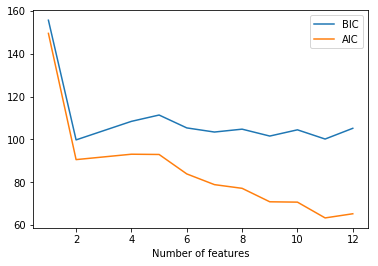

In [15]:
number_of_features = range(1, len(X.columns) + 1)
aics = [carry_out_recursive_feature_elimination(n_features_to_select=i, X=X, Y=Y).aic
        for i in number_of_features]
bics = [carry_out_recursive_feature_elimination(n_features_to_select=i, X=X, Y=Y).bic
        for i in number_of_features]
plt.figure()
plt.plot(number_of_features, bics, label="BIC")
plt.plot(number_of_features, aics, label="AIC")
plt.legend()
plt.xlabel("Number of features");

2 and 11 features seem sensible.

In [28]:
model = carry_out_recursive_feature_elimination(n_features_to_select=2, X=X, Y=Y)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     36.53
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           9.74e-14
Time:                        16:33:08   Log-Likelihood:                -42.272
No. Observations:                 159   AIC:                             90.54
Df Residuals:                     156   BIC:                             99.75
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.2815      0.056     22.993      0.000       1.171       1.392
('residual', 'mean')      -1.0620      0.145     -7.323      0.000      -1.348      -0.776
('residual', 'median')     0.9037      0.106      8.535      0.000       0.695       1.113
==============================================================================
Omnibus:                        2.302   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.316   Jarque-Bera (JB):                1.850
Skew:                          -0.199   Prob(JB):                        0.397
Kurtosis:                       3.348   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mean SSerror reduces fixation, median increases it. This strategies with long tail (positive skew) distributions (giving a large mean and a low median) have a low fixation whereas strategies with a negative skew will be more likely to become fixed. This implies that strategies that usually don't act in a ZD way but can adapt to do so will behave well in an evolutionary setting.

In [29]:
model = carry_out_recursive_feature_elimination(n_features_to_select=11, X=X, Y=Y)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     12.71
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           1.09e-16
Time:                        16:33:16   Log-Likelihood:                -19.663
No. Observations:                 159   AIC:                             63.33
Df Residuals:                     147   BIC:                             100.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.3527      0.140      9.677      0.000       1.076       1.629
('residual', 'mean')      -1.3278      0.248     -5.347      0.000      -1.819      -0.837
('residual', 'median')     1.0751      0.176      6.119      0.000       0.728       1.422
('residual', 'std')       -2.4460      1.016     -2.407      0.017      -4.454      -0.438
('residual', 'max')        0.3685      0.095      3.897      0.000       0.182       0.555
('residual', 'min')       -0.3763      0.206     -1.824      0.070      -0.784       0.032
('residual', 'var')        2.3670      1.469      1.611      0.109      -0.536       5.270
('chi', 'mean')            0.0431      0.011      3.871      0.000       0.021       0.065
('chi', 'median')         -0.0700      0.015     -4.633      0.000      -0.100      -0.040
('chi', 'std')             0.0054      0.001      4.037      0.000       0.003       0.008
('chi', 'max')            -0.0006      0.000     -3.232      0.002      -0.001      -0.000
('chi', 'min')             0.0001   3.67e-05      2.987      0.003    3.71e-05       0.000
==============================================================================
Omnibus:                        0.681   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.712   Jarque-Bera (JB):                0.358
Skew:                          -0.066   Prob(JB):                        0.836
Kurtosis:                       3.192   Cond. No.                     1.93e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let us double check that RSE is working properly using brute force.

In [30]:
import itertools

def iterate_over_all_variables(number_of_features=2):
    for variables in itertools.product(X.columns, repeat=number_of_features):
        x = sm.add_constant(X[list(variables)])
        model = sm.OLS(Y, x).fit()
        yield variables, model.rsquared

In [31]:
max(iterate_over_all_variables(number_of_features=2), key=lambda x: x[1])

((('residual', 'median'), ('residual', 'mean')), 0.31894117682467416)

In [32]:
max(iterate_over_all_variables(number_of_features=3), key=lambda x: x[1])

((('residual', 'median'), ('chi', 'median'), ('residual', 'mean')),
 0.3510381294517789)